# Settings

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
from kaucherpy import *

# Task 1

$A \cdot x = b$

$A = \left(\begin{matrix}1 & 1 \\ 0 & 0.1 \end{matrix}\right); b = \left(\begin{matrix}[4.1, 3.9] \\ [0.1, 0.2]\end{matrix}\right)$

## Create A & b

In [2]:
a_slae = np.array([[1, 1], [0, 0.1]])

inf_b = np.array([4.1, 0.1])
sup_b = np.array([3.9, 0.2])

## Define sti

$KR^n \rightarrow R^{2n}$

In [3]:
def sti_vector(x_inf, x_sup):
    return np.hstack([-x_inf, x_sup])

def back_sti_vector(sti_vec):
    half = sti_vec.shape[0] // 2
    x_inf = -sti_vec[:half]
    x_sup = sti_vec[half:]
    return (x_inf, x_sup)

def sti_dot_mtx(a_mtx):
    a_plus = np.zeros(a_mtx.shape)
    a_minus = np.zeros(a_mtx.shape)
    for i in range(a_mtx.shape[0]):
        for j in range(a_mtx.shape[1]):
            if (a_mtx[i][j] > 0):
                a_plus[i][j] = a_mtx[i][j]
            else:
                a_minus[i][j] = -a_mtx[i][j]
    return np.block([[a_plus, a_minus], [a_minus, a_plus]])

### Test sti

In [4]:
tmp = np.array([1, -3])
tmp_sup = np.array([2, 4])
sti = sti_vector(tmp, tmp_sup)
print(sti)
tmp, tmp_sup = back_sti_vector(sti)
print(tmp)
print(tmp_sup)

a_mtx = np.array([[1, 2], [-3, 4]])
print(sti_dot_mtx(a_mtx))

[-1  3  2  4]
[ 1 -3]
[2 4]
[[1. 2. 0. 0.]
 [0. 4. 3. 0.]
 [0. 0. 1. 2.]
 [3. 0. 0. 4.]]


## Calculate $G(y)$, $y \in R^{n \times n}$

In [13]:
def compute_G(C_mtx, cur_point, d_sti):
    intervaled_inf, intervaled_sup = back_sti_vector(cur_point)
    y_interval = [Kaucher(intervaled_inf[i], intervaled_sup[i]) for i in range(intervaled_inf.shape[0])]
    dot_prod = [sum([C_mtx[i][j] * y_interval[j] for j in range(len(y_interval))]) for i in range(len(C_mtx))]
    prod_lower = np.array([comp.lower for comp in dot_prod])
    prod_upper = np.array([comp.upper for comp in dot_prod])
    return sti_vector(prod_lower, prod_upper) - d_sti 

## Calculate $x^{(0)} \in R^{n \times n}$

In [14]:
def compute_x0(mid_C, sti_d):
    return np.linalg.solve(mid_C, sti_d)

## Calculate subgradient D

In [15]:
def compute_D(D, i, j, a_ij, b_inf, b_sup):
    n = D.shape[0] // 2;
    
    ainf = a_ij.lower
    asup = a_ij.upper
    
    # determine case (1 of 16)
    k = 0
    m = 0
    if ainf * asup > 0:
        k = 0 if ainf > 0 else 2
    else:
        k = 1 if ainf < asup else 3
    
    if b_inf * b_sup > 0:
        m = 1 if b_inf > 0 else 3
    else:
        m = 2 if b_inf <= b_sup else 4
        
    case = 4 * k + m
    if case == 1:
        D[i, j] = ainf
        D[i + n, j + n] = asup
    elif case == 2:
        D[i, j] = asup
        D[i + n, j + n] = asup
    elif case == 3:
        D[i, j] = asup
        D[i + n, j + n] = ainf
    elif case == 4:
        D[i, j] = ainf
        D[i + n, j + n] = ainf
    elif case == 5:
        D[i, j + n] = ainf
        D[i + n, j + n] = asup
    elif case == 6:
        if ainf * b_sup < asup * b_inf:
            D[i, j + n] = ainf
        else:
            D[i, j] = asup
        if ainf * b_inf > asup * b_sup:
            D[i + n, j] = ainf
        else:
            D[i + n, j + n] = asup
    elif case == 7:
        D[i, j] = asup
        D[i + n, j] = ainf
    elif case == 8:
        pass  # zeroes are already filled
    elif case == 9:
        D[i, j + n] = ainf
        D[i + n, j] = asup
    elif case == 10:
        D[i, j + n] = ainf
        D[i + n, j] = ainf
    elif case == 11:
        D[i, j + n] = asup
        D[i + n, j] = ainf
    elif case == 12:
        D[i, j + n] = asup
        D[i + n, j] = asup
    elif case == 13:
        D[i, j] = ainf
        D[i + n, j] = asup
    elif case == 14:
        pass  # zeros are already filled
    elif case == 15:
        D[i, j + n] = asup
        D[i + n, j + n] = ainf
    elif case == 16:
        if ainf * b_inf > asup * b_sup:
            D[i, j] = ainf
        else:
            D[i, j + n] = -asup
        if ainf * b_sup < asup * b_inf:
            D[i + n, j + n] = ainf
        else:
            D[i + n, j] = asup
    return D
    #if a_ij > 0:  # old code (non-interval mtx)
    #    D[i, j] = a_ij
    #    D[i + n, j + n] = a_ij
    #else:
    #    D[i, j + n] = a_ij
    #    D[i + n, j] = a_ij
    #return D

# Subgradient Newton method

In [156]:
def subdiff2(A_inf, A_sup, inf_b, sup_b):
    # params
    learning_rate = 0.8
    accuracy = 1e-8
    max_iter = 40
    
    n = A_inf.shape[0]  # dim
    
    # compute x0
    A_mid = np.array([[(A_inf[i, j] + A_sup[i, j]) / 2 for j in range(n)] for i in range(n)])
    A = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
    C_sti = sti_dot_mtx(A_mid)  # for x0
    d_sti = sti_vector(inf_b, sup_b)  # for x0
    #cur_x = compute_x0(C_sti, d_sti)  # x0: (mid C)~ x0 = sti(b) 
    cur_x = np.zeros(d_sti.shape[0])  # x0 = 0
    
    prev_x = cur_x
    started = False  # to enter the first iteration

    # do until method converges
    cur_iter = 0
    worklist = [cur_x]  # return each step
    while not started or np.linalg.norm(cur_x - prev_x) > accuracy:
        started = True
        cur_iter += 1
        if (cur_iter > max_iter):
            print("Too many iterations")
            break
        prev_x = cur_x  # update after the previous step
        D = np.zeros((2 * n, 2 * n))  # subgrad mtx
        for i in range(n):
            for j in range(n):
                g = A[i][j]                
                h_inf = -prev_x[j]
                h_sup = prev_x[j + n]
                D = compute_D(D, i, j, g, h_inf, h_sup)
        G_part = compute_G(A, prev_x, d_sti)
        dx = np.linalg.solve(D, -G_part)
        cur_x = prev_x + learning_rate * dx
        worklist.append(cur_x)
    print(f"Iteration count: {cur_iter}")
    return back_sti_vector(cur_x), worklist

# Make plots

In [157]:
def make_plot_solution(mtx_inf, mtx_sup, x, inf_b, sup_b, filename):
    n = mtx_inf.shape[0]
    b_dot_inf = np.dot(mtx_inf, x)
    b_dot_sup = np.dot(mtx_sup, x)
    if n > 60:  # plot only 100 first points
        n = 60
    plt.plot(b_dot_inf[:n], label='inf(Ax)')
    plt.plot(b_dot_sup[:n], label='sup(Ax)')
    plt.plot(inf_b[:n], label='inf(b)')
    plt.plot(sup_b[:n], label='sup(b)')
    plt.legend()
    plt.xlabel('i')
    plt.ylabel(r"$b_i$")
    plt.title('Solution plot')
    plt.savefig(filename)
    plt.show()
    plt.close()
    
def make_plot_convergence(worklist, filename):
    norms = [np.linalg.norm(worklist[i + 1] - worklist[i]) for i in range(len(worklist) - 1)]
    plt.plot(norms)
    plt.xlabel('k')
    plt.ylabel(r"$||x^{(k + 1)} - x^{(k)}||$")
    plt.title('Norm reduction plot')
    plt.savefig(filename)
    plt.show()
    plt.close()

def make_plot_solution2(mtx_inf, mtx_sup, x_inf, x_sup, inf_b, sup_b, filename):
    n = mtx_inf.shape[0]
    mtx_interval = [[Kaucher(mtx_inf[i,j], mtx_sup[i,j]) for j in range(n)] for i in range(n)]
    x_interval = [Kaucher(x_inf[i], x_sup[i]) for i in range(n)]
    b_interval = [sum([mtx_interval[i][j] * x_interval[j] for j in range(n)]) for i in range(n)]
    inf_b_sol = np.array([comp.lower for comp in b_interval])
    sup_b_sol = np.array([comp.upper for comp in b_interval])
    if n > 60:  # plot only 100 first points
        n = 60
    plt.plot(inf_b[:n], label='inf(b)')
    plt.plot(inf_b_sol[:n], label='inf(Ax)', linestyle='dotted')
    plt.plot(sup_b[:n], label='sup(b)')
    plt.plot(sup_b_sol[:n], label='sup(Ax)', linestyle='dotted')
    plt.xlabel('i')
    plt.ylabel(r"$b_{i}$")
    plt.title("Check solution")
    plt.legend()
    plt.savefig(filename)
    plt.show()
    plt.close()
    
def make_plot_matrix(mtx, filename):
    plt.pcolormesh(mtx)
    plt.xlabel('i')
    plt.ylabel('j')
    plt.title('Matrix')
    plt.colorbar()
    plt.savefig(filename)
    plt.show()
    plt.close()

## Test with interval small matrix

Iteration count: 14
X inf: [3.1 1. ]
X sup: [2.9 1. ]


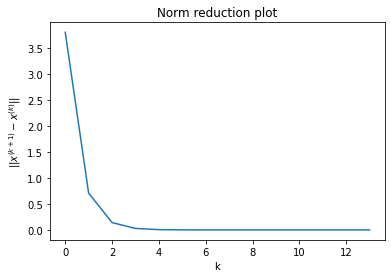

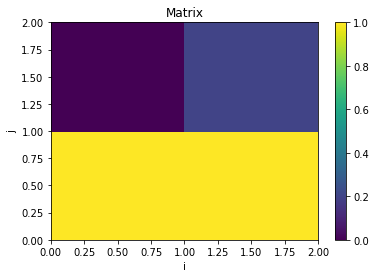

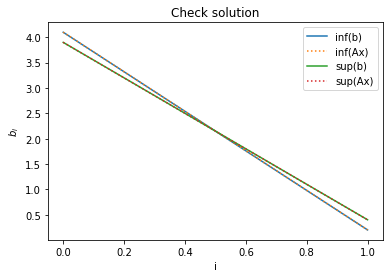

In [158]:
a_slae_inf = np.array([[1, 1], [0, 0.2]])
a_slae_sup = np.array([[1, 1], [0, 0.4]])

inf_b = np.array([4.1, 0.2])
sup_b = np.array([3.9, 0.4])

(x_inf, x_sup), worklist = subdiff2(a_slae_inf, a_slae_sup, inf_b, sup_b)
print(f"X inf: {x_inf}")
print(f"X sup: {x_sup}")

make_plot_convergence(worklist, os.path.join('output', 'sys0worklist.png'))
make_plot_matrix(a_slae_inf, os.path.join('output', 'matrix0.png'))
#make_plot_solution(a_slae_inf, a_slae_sup, x_inf, inf_b, sup_b, os.path.join('output', 'sys0ax.png'))
make_plot_solution2(a_slae_inf, a_slae_sup, x_inf, x_sup, inf_b, sup_b, os.path.join('output', 'sys0solution.png'))

# Task 2

## Get square matrices

In [159]:
def get_square(mtx):
    mtx_shape = mtx.shape
    result_n = min(mtx_shape[0], mtx_shape[1])
    return mtx[:result_n,:result_n]

## Make diagonal dominant matrices
### Method requires diagonal dominant matrices

In [160]:
# check if matrix diagonal dominant
def diagonal_dominant(mtx):
    D = np.diag(np.abs(mtx)) # get diagonal
    E = np.sum(np.abs(mtx), axis=1) - D # row sum without diagonal elements
    return np.all(D > E)  # true if the matrix is diagonal dominant

# make matrix diagonal dominant
# (add diagonal matrix to achieve diagonal domination)
def make_diagonal_dominant(mtx):
    if diagonal_dominant(mtx):
        return mtx  # don't need to change matrix
    D = np.diag(np.abs(mtx))  # get diagonal
    E = np.sum(np.abs(mtx), axis=1) - D  # row sum
    eps = 0.1  # diag - sum > eps
    for i in range(mtx.shape[0]):
        if D[i] - E[i] <= eps:  # find bad lines
            mtx[i,i] += E[i] - D[i] + eps  # increase diag elements
    return mtx

## Generate right part

In [161]:
def generate_right_part(mtx):
    n = mtx.shape[0]
    x = np.random.uniform(low=1, high=5, size=n)
    b = np.dot(mtx, x)  # get right part
    rads = np.random.uniform(low=0.5, high=2, size=n)  # generate radiuses for b
    b_inf = b - rads  # make b interval
    b_sup = b + rads
    return b_inf, b_sup, x

## Create & solve task

In [171]:
def make_mtx_interval(mtx):
    n = mtx.shape[0]
    rads = np.random.uniform(low=0.1, high=0.5, size=(n, n))
    mtx_inf = mtx - rads
    mtx_sup = mtx + rads
    return mtx_inf, mtx_sup

def solve_task_2(mtx):
    mtx = make_diagonal_dominant(mtx)
    b_inf, b_sup, x_ground_truth = generate_right_part(mtx)
    (x_inf, x_sup), worklist = subdiff2(mtx, mtx, b_inf, b_sup)
    #print(f"X inf: {x_inf}")
    #print(f"X sup: {x_sup}")
    return x_inf, x_sup, worklist, x_ground_truth, b_inf, b_sup, mtx, mtx

def solve_task_3(mtx):
    mtx = make_diagonal_dominant(mtx)
    b_inf, b_sup, x_true = generate_right_part(mtx)
    mtx_inf, mtx_sup = make_mtx_interval(mtx)
    (x_inf, x_sup), worklist = subdiff2(mtx_inf, mtx_sup, b_inf, b_sup)
    return x_inf, x_sup, worklist, x_true, b_inf, b_sup, mtx_inf, mtx_sup

In [168]:
def completeSolveSingle(outdir, slae_number, input_file):
    in_dir= 'input'
    n_phi = np.loadtxt(os.path.join(in_dir, input_file))
    
    # see shape
    print(f"Matrix {slae_number} shape: {n_phi.shape}")
    
    # get square mtx
    a_slae_n = get_square(n_phi)
    
    print(f"System {slae_number} solution:")
    comments = ['task_2', 'task_3']
    for i, task in enumerate([solve_task_2, solve_task_3]):
        x_inf, x_sup, worklist, x, b_inf, b_sup, mtx_inf, mtx_sup = task(a_slae_n)
        print(f"The last norm: {np.linalg.norm(worklist[-1] - worklist[-2])}")
        
        if i == 0:
            # save
            np.savetxt(os.path.join(outdir, f"x_inf_slae_{slae_number}.txt"), x_inf)
            np.savetxt(os.path.join(outdir, f"x_sup_slae_{slae_number}.txt"), x_sup)
            np.savetxt(os.path.join(outdir, f'n_phi_{slae_number}_mtx.txt'), a_slae_n, fmt='%g')
    
        # plots
        make_plot_convergence(worklist, os.path.join('output', f"sys{slae_number}worklist{comments[i]}.png"))
        make_plot_solution(mtx_inf, mtx_sup, x, b_inf, b_sup, os.path.join('output', f'sys{slae_number}rightPart{comments[i]}.png'))
        make_plot_solution2(mtx_inf, mtx_sup, x_inf, x_sup, b_inf, b_sup, os.path.join('output', f'sys{slae_number}solution{comments[i]}.png'))
        if i == 0:
            make_plot_matrix(a_slae_n, os.path.join('output', f'matrix{slae_number}.png'))            

In [169]:
def completeSolveBoth(outdir):
    mtx_files = ['matrix_n_phi_1.txt', 'matrix_n_phi_6.txt']
    slae_numbers = [2, 3]
    for i, cur_slae in enumerate(slae_numbers):
        completeSolveSingle(outdir, cur_slae, mtx_files[i])

Matrix 2 shape: (256, 36)
System 2 solution:
Iteration count: 15
The last norm: 3.56323032654058e-09


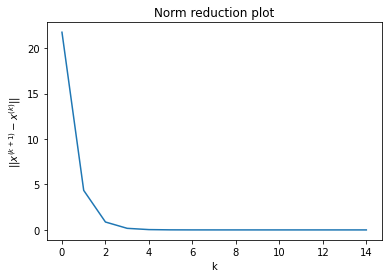

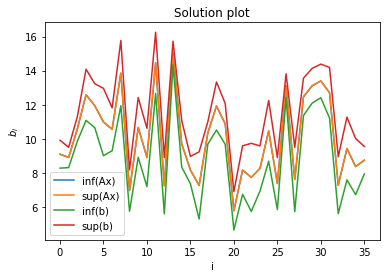

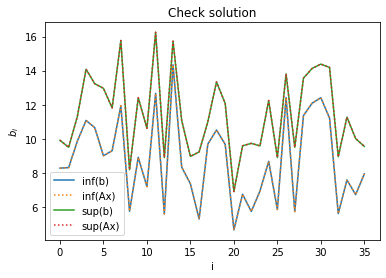

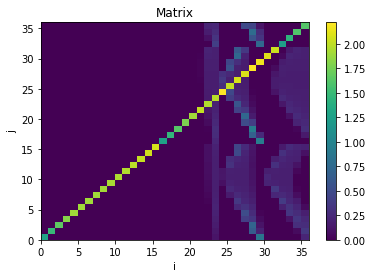

Iteration count: 19
The last norm: 9.706332512399761e-09


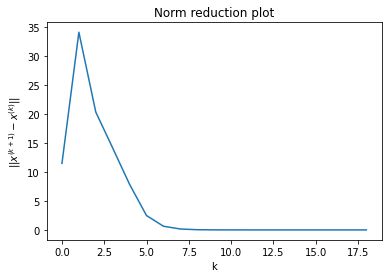

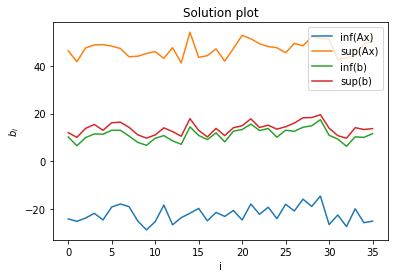

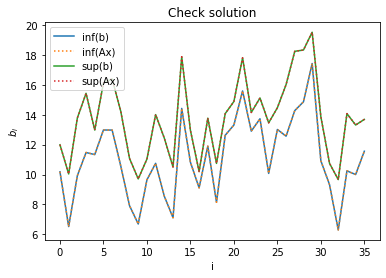

Matrix 3 shape: (256, 216)
System 3 solution:
Iteration count: 15
The last norm: 8.858947056401272e-09


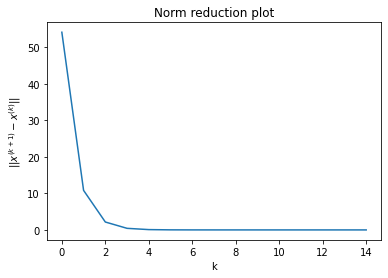

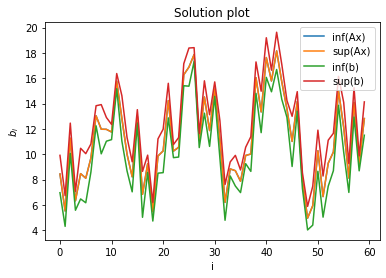

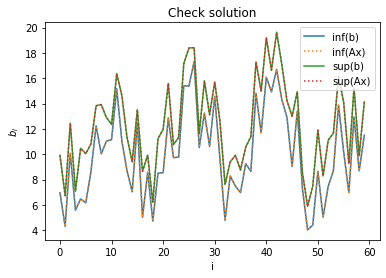

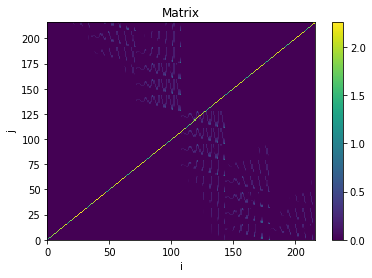

Iteration count: 22
The last norm: 6.945103882972781e-09


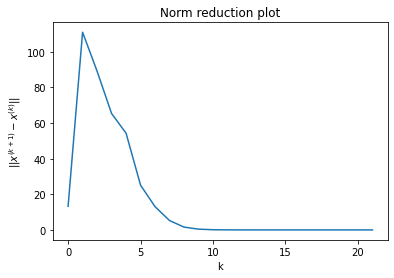

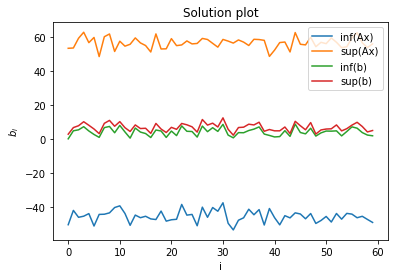

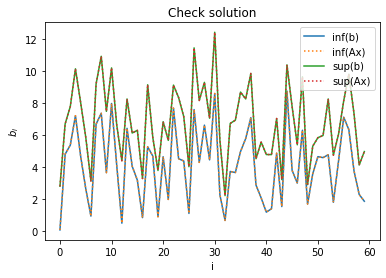

In [170]:
completeSolveBoth('output')